In [1]:
from utils.load_data import load_data
from utils.filters import highpass_filter, lowpass_filter
import numpy as np
from utils.plot_signal import plot_signal
import matplotlib.pyplot as plt

In [2]:
# Load data
data_abdomen1, data_abdomen2, data_abdomen3, data_thorax1, data_thorax2 = load_data()

# Preprocessing & Signal Processing
1. normalization
2. high pass filter
3. low pass filter
4. 

#### Failed attempts
1. Naive first approach of subtraction - could not successfully isolate.
2. Band-pass filtering - gives signal which looks like sinusoid.
3. Removing combined signal maximums to try and obtain child. Noise was problematic and combined signal wasnt able to be disected.

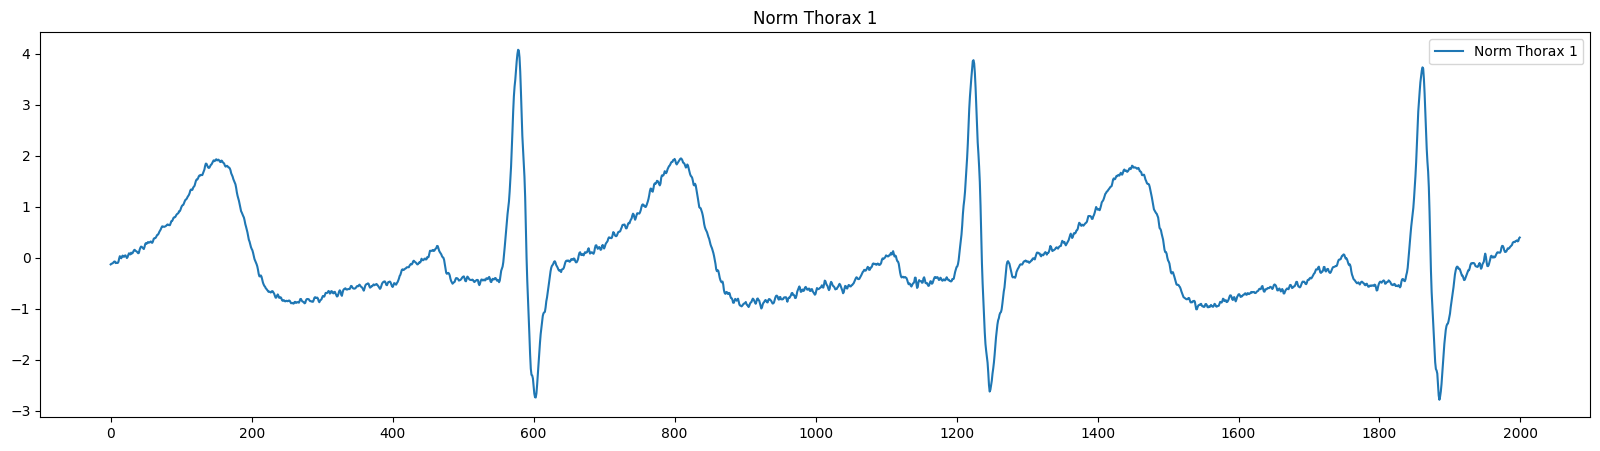

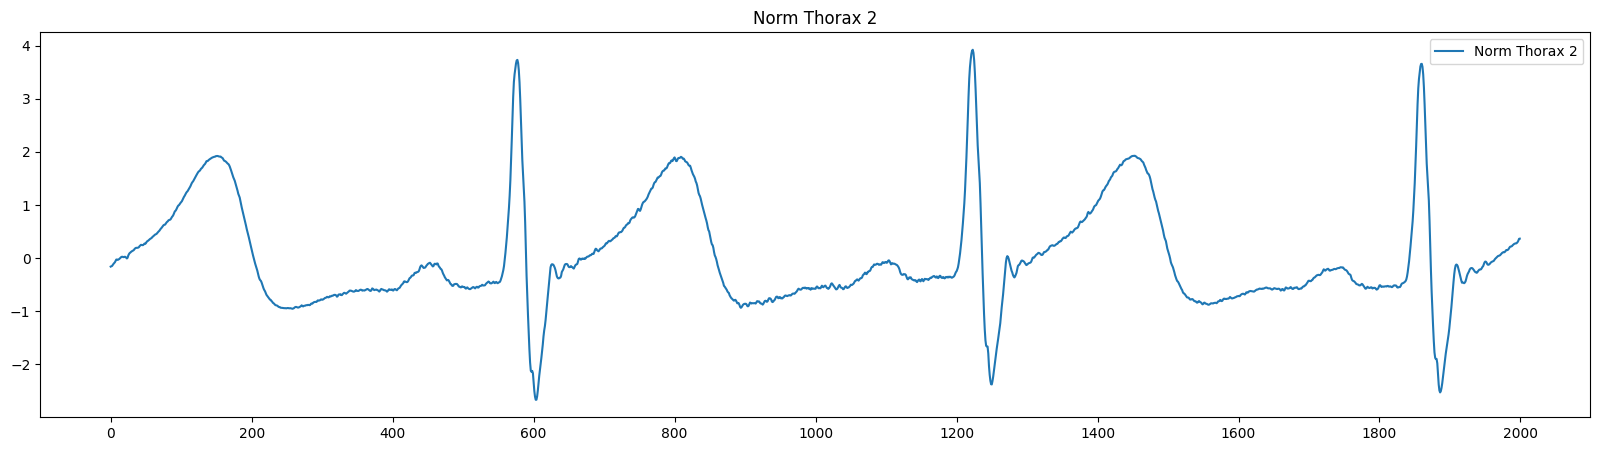

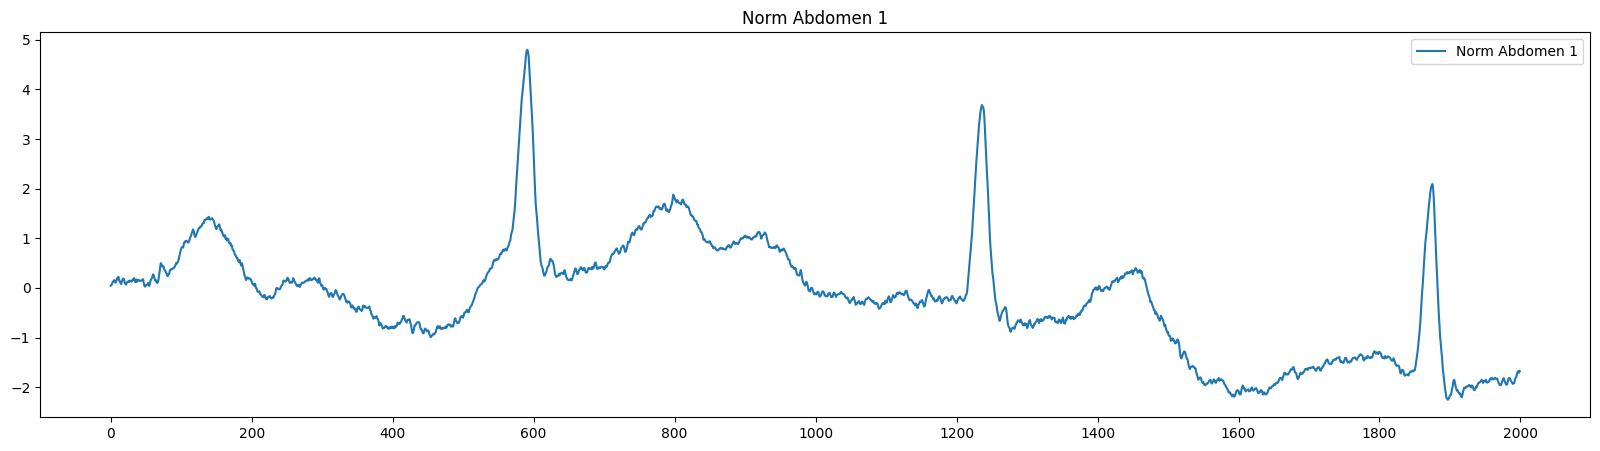

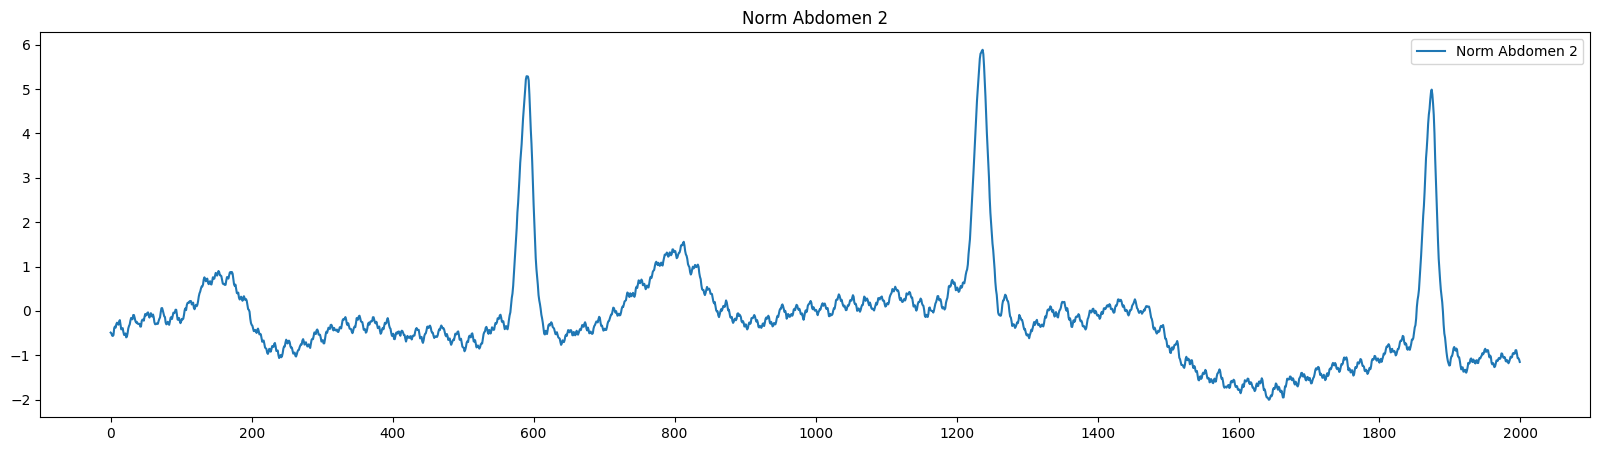

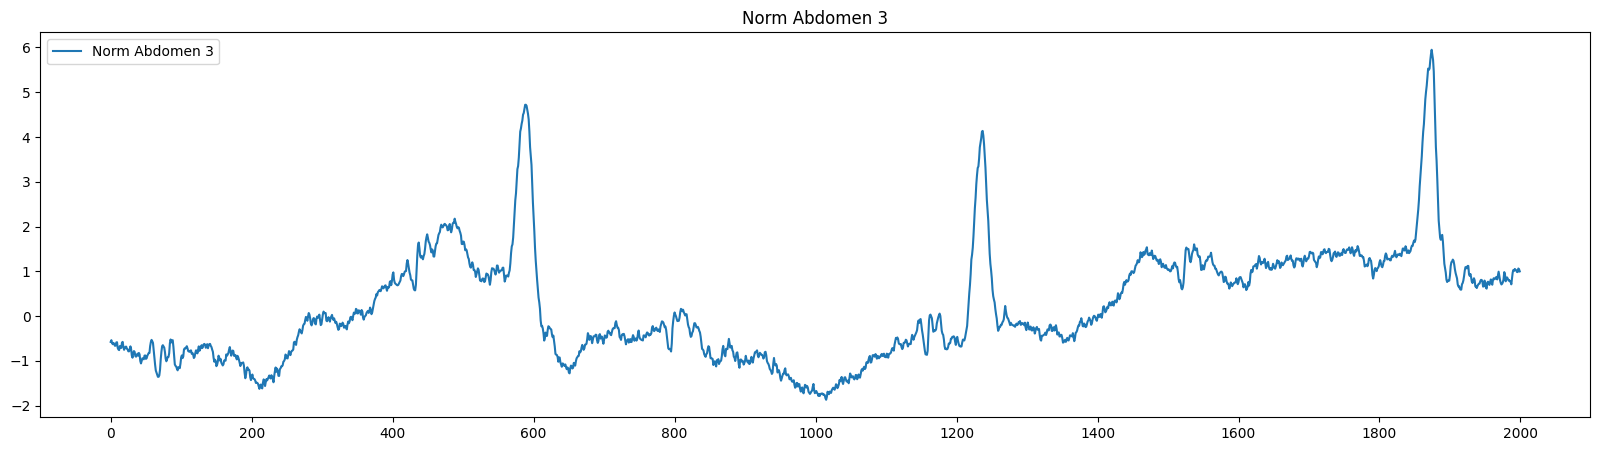

In [3]:
# thorax1 = data_thorax1
# thorax2 = data_thorax2
# abdomen1 = data_abdomen1
# abdomen2 = data_abdomen2
# abdomen3 = data_abdomen3

# Normalize the data to unit variance and zero mean
thorax1 = (data_thorax1 - data_thorax1.mean()) / data_thorax1.std()
thorax2 = (data_thorax2 - data_thorax2.mean()) / data_thorax2.std()
abdomen1 = (data_abdomen1 - data_abdomen1.mean()) / data_abdomen1.std()
abdomen2 = (data_abdomen2 - data_abdomen2.mean()) / data_abdomen2.std()
abdomen3 = (data_abdomen3 - data_abdomen3.mean()) / data_abdomen3.std()


plot_signal(thorax1, 'Norm Thorax 1')
plot_signal(thorax2, 'Norm Thorax 2')
plot_signal(abdomen1, 'Norm Abdomen 1')
plot_signal(abdomen2, 'Norm Abdomen 2')
plot_signal(abdomen3, 'Norm Abdomen 3')


#### High Pass Filter
Why do we use it?

Parameter justification:
  - 
  -
  -

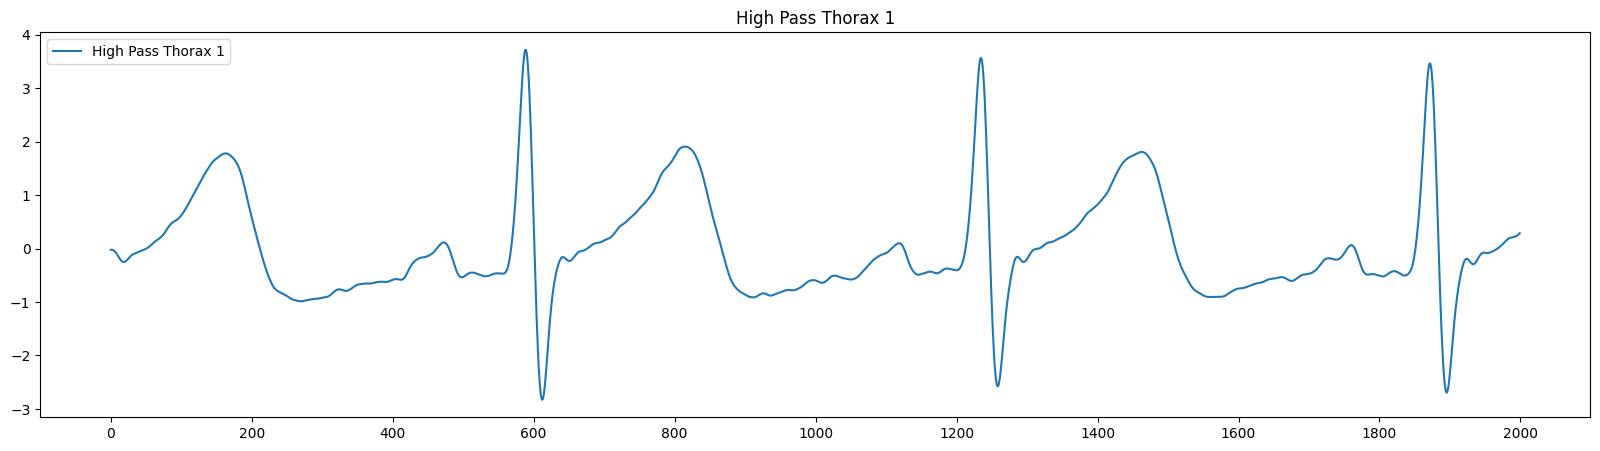

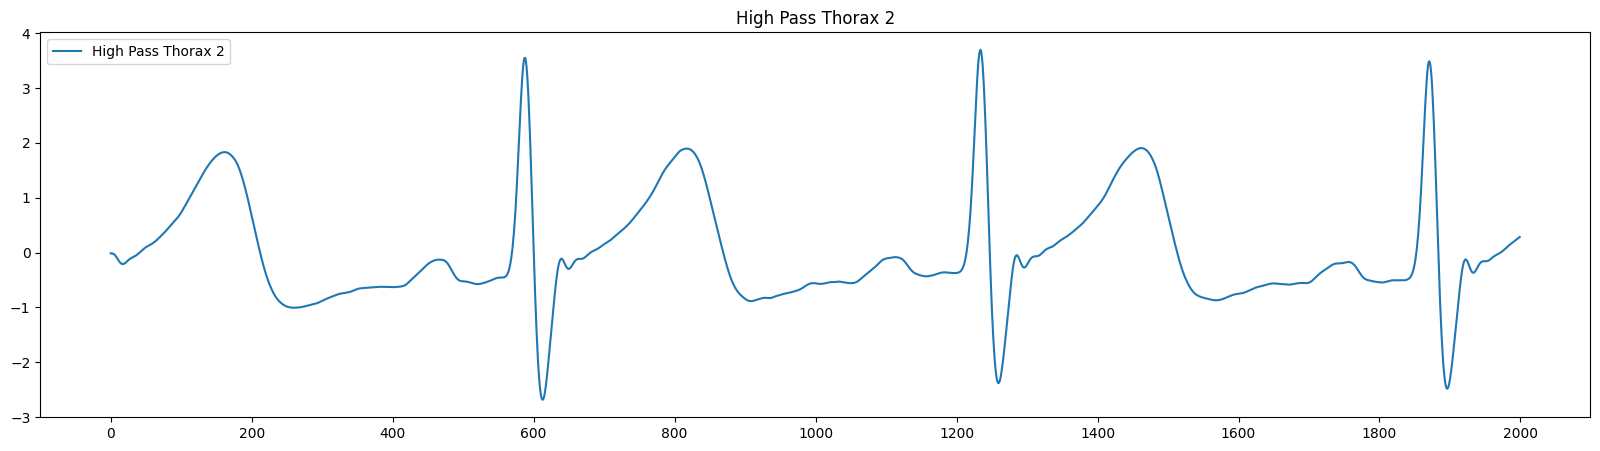

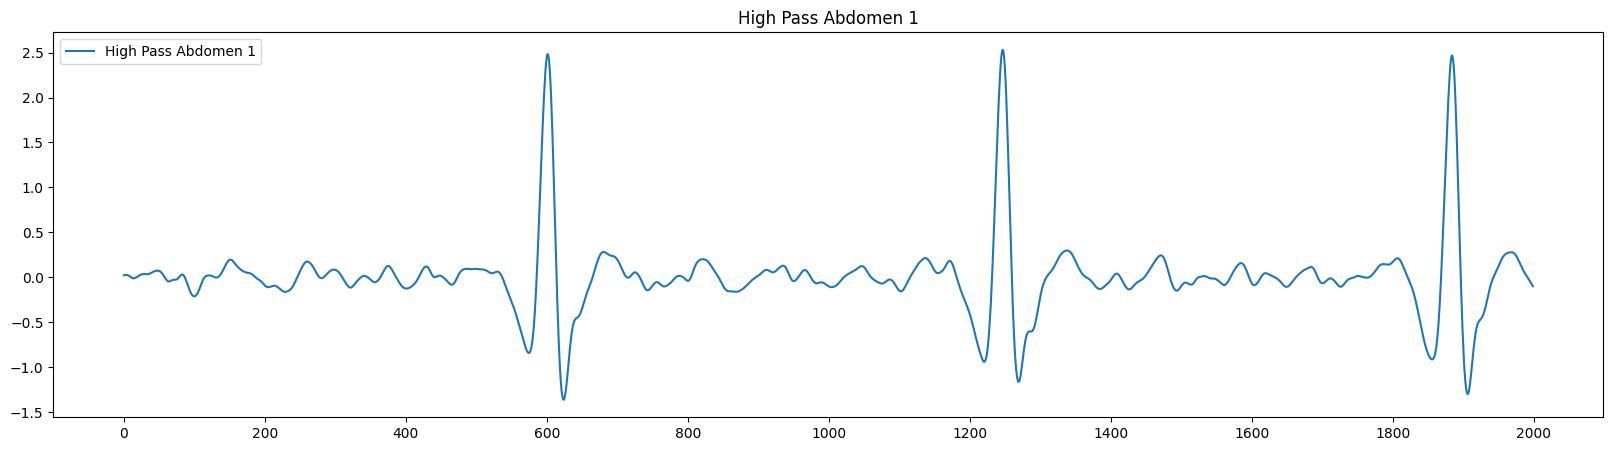

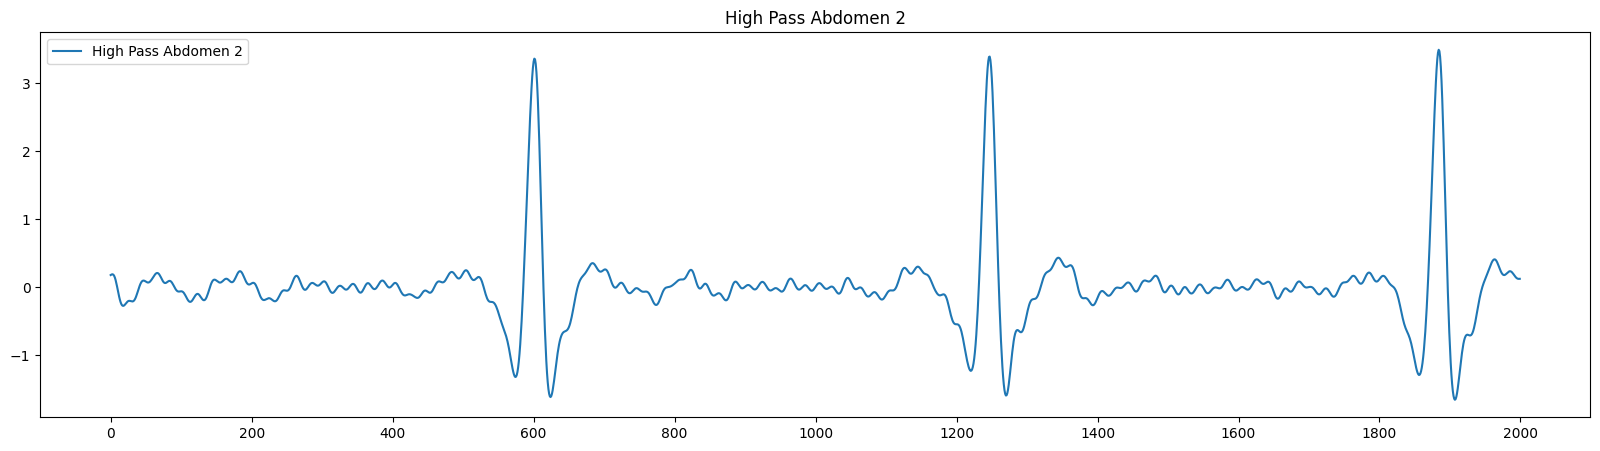

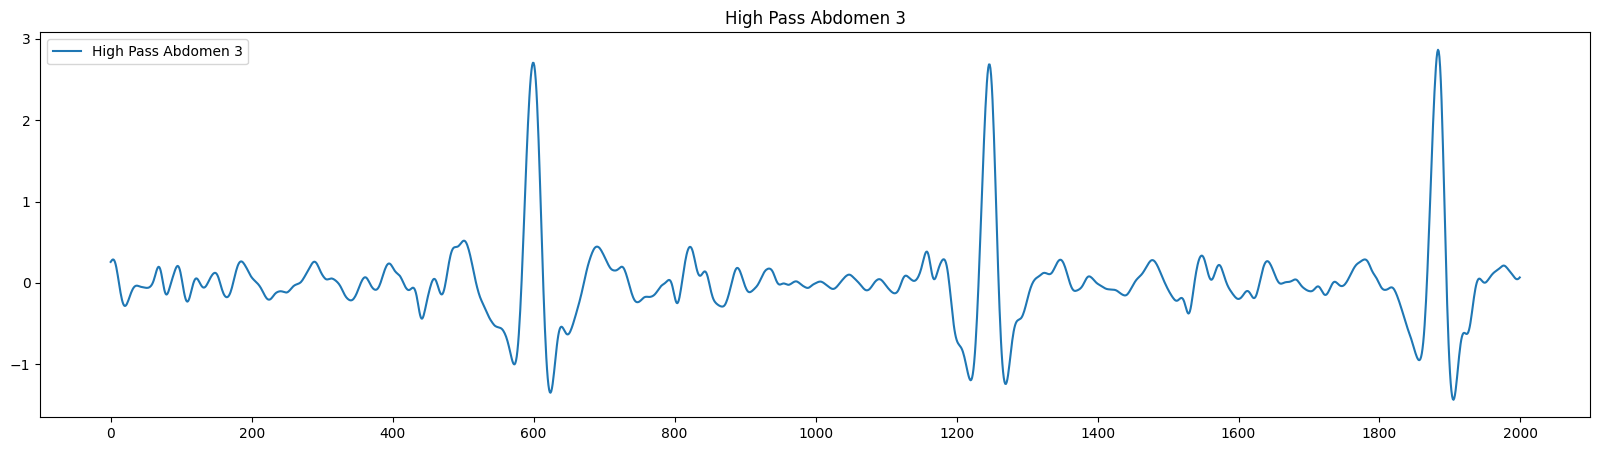

In [6]:
# High pass filter to remove baseline wander
cutoff_baseline_thorax = 0.5
cutoff_baseline_abdomen = 8
fs = 1000

thorax1 = highpass_filter(thorax1, cutoff_baseline_thorax, fs)
thorax2 = highpass_filter(thorax2, cutoff_baseline_thorax, fs)
abdomen1 = highpass_filter(abdomen1, cutoff_baseline_abdomen, fs)
abdomen2 = highpass_filter(abdomen2, cutoff_baseline_abdomen, fs)
abdomen3 = highpass_filter(abdomen3, cutoff_baseline_abdomen, fs)

# TEMPORARY
# Plot signal with high pass filter applied
plot_signal(thorax1, "High Pass Thorax 1")
plot_signal(thorax2, "High Pass Thorax 2")
plot_signal(abdomen1, "High Pass Abdomen 1")
plot_signal(abdomen2, "High Pass Abdomen 2")
plot_signal(abdomen3, "High Pass Abdomen 3")

#### Low Pass Filter
Why do we use it?

Parameter Justification:
  - 
  -
  -

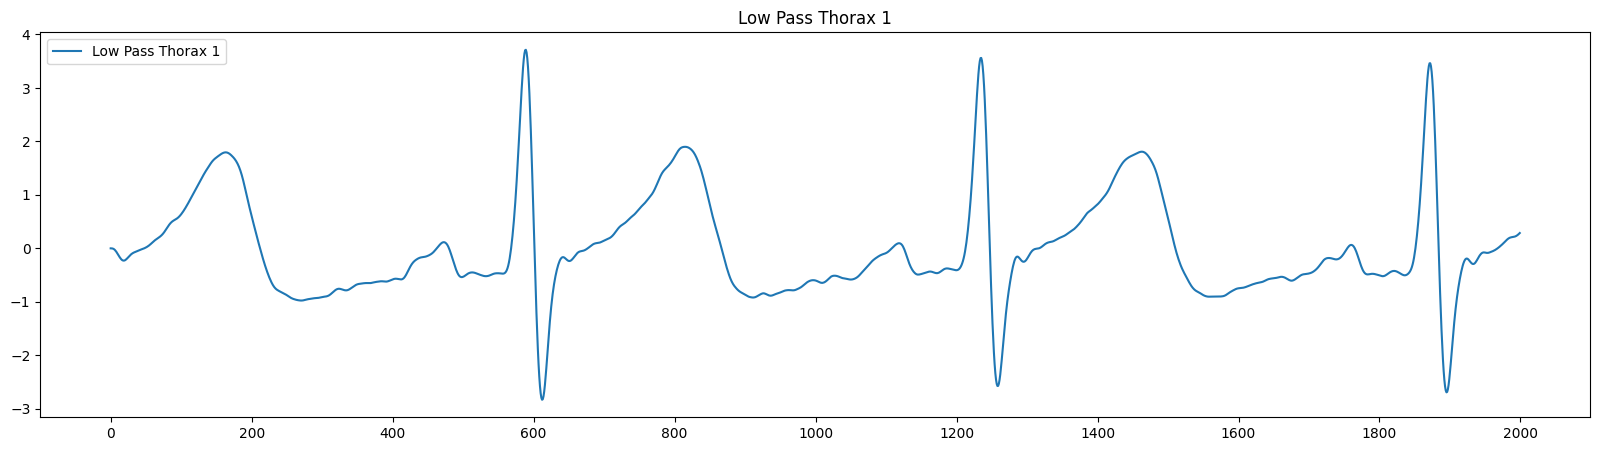

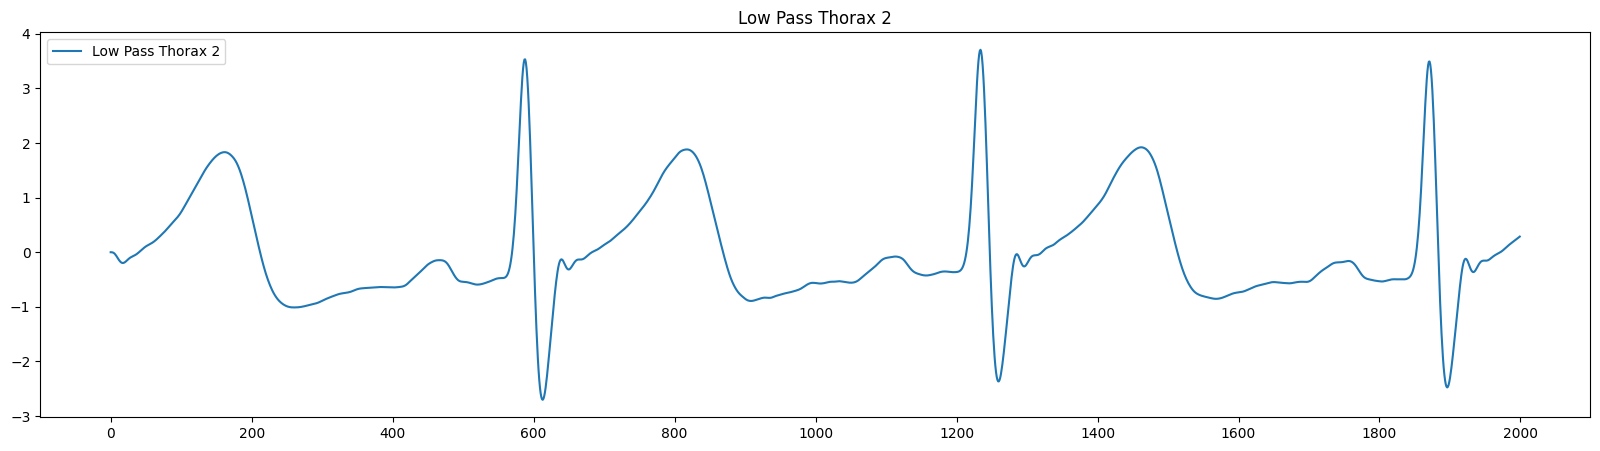

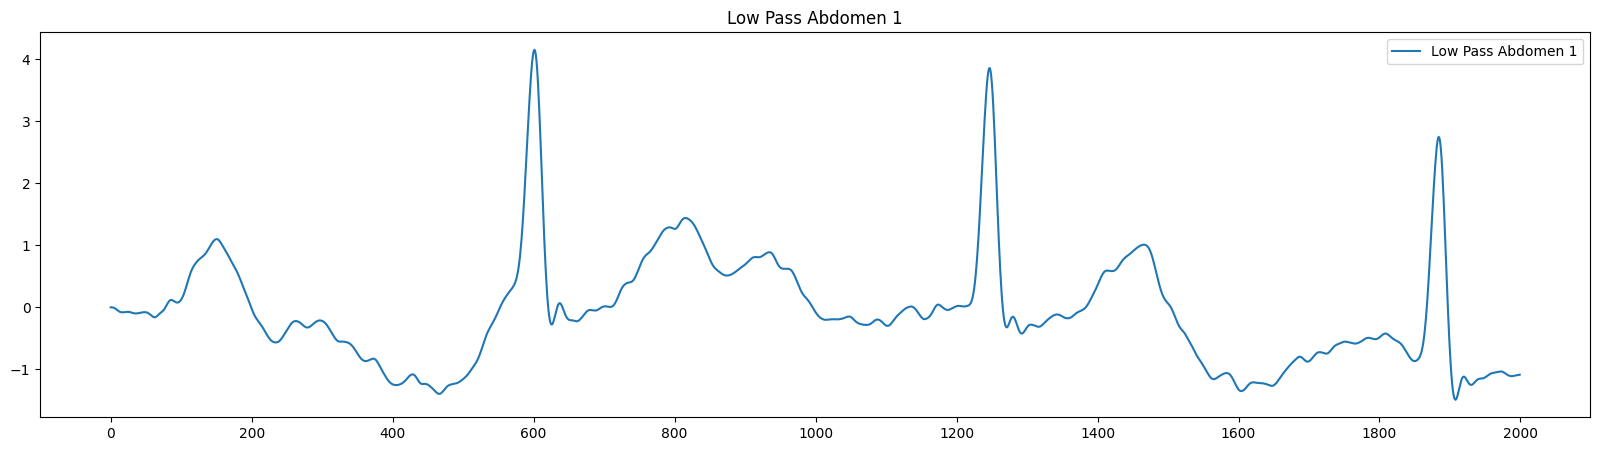

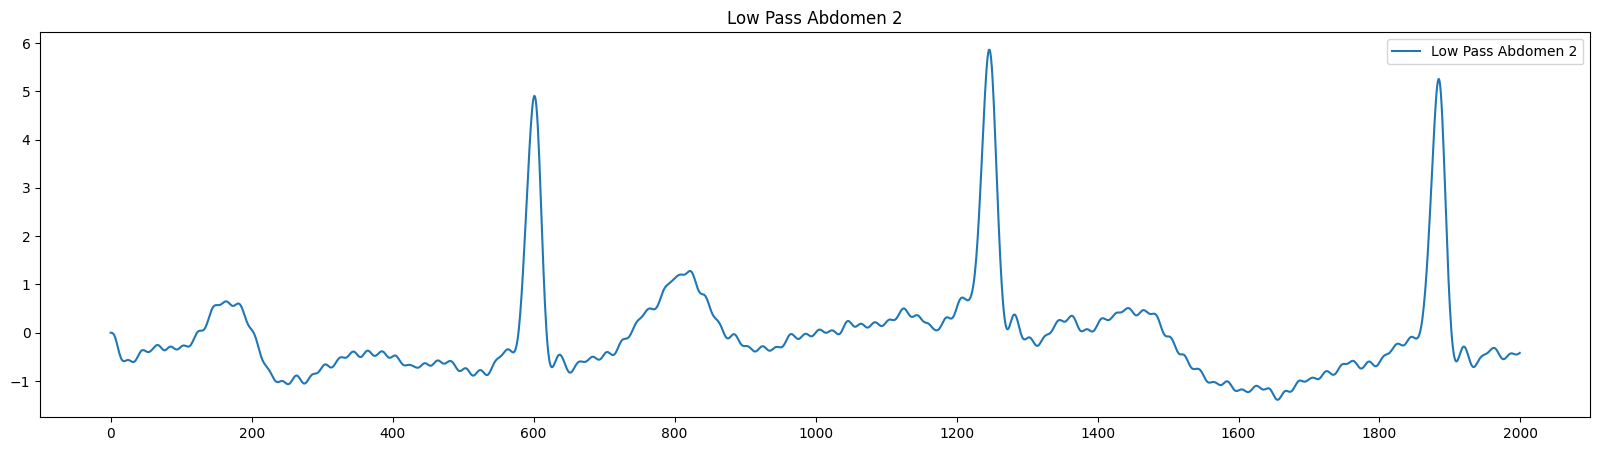

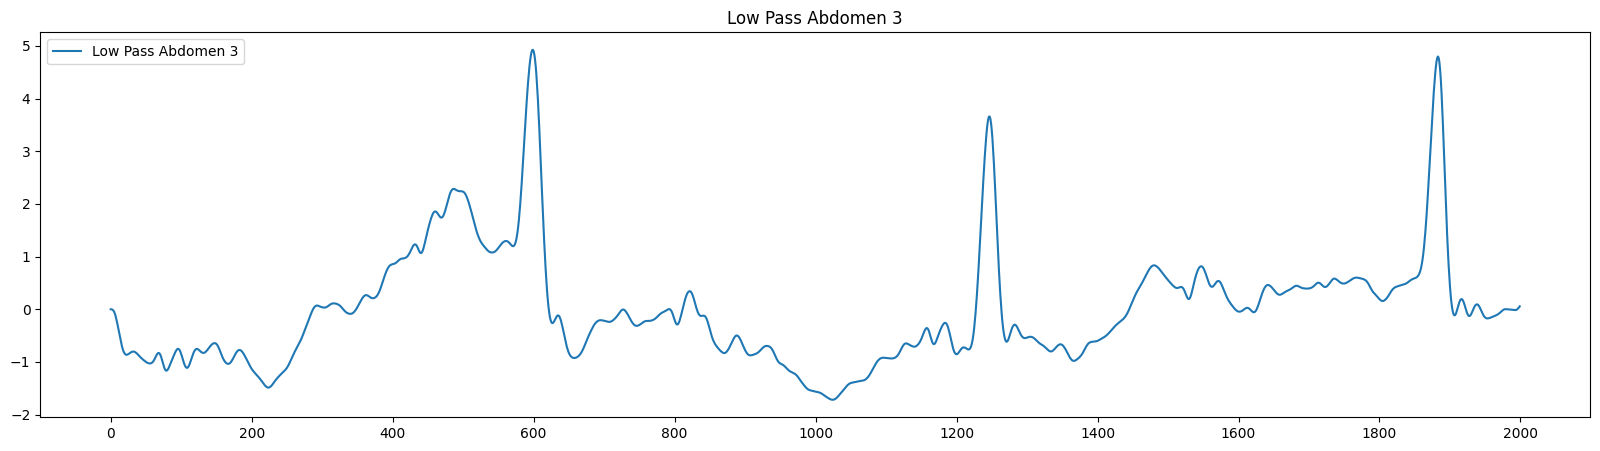

In [5]:
thorax1 = lowpass_filter(thorax1, 40, fs)
thorax2 = lowpass_filter(thorax2, 40, fs)
abdomen1 = lowpass_filter(abdomen1, 40, fs)
abdomen2 = lowpass_filter(abdomen2, 40, fs)
abdomen3 = lowpass_filter(abdomen3, 40, fs)

# Plot signal with low pass filter applied
plot_signal(thorax1, "Low Pass Thorax 1")
plot_signal(thorax2, "Low Pass Thorax 2")
plot_signal(abdomen1, "Low Pass Abdomen 1")
plot_signal(abdomen2, "Low Pass Abdomen 2")
plot_signal(abdomen3, "Low Pass Abdomen 3")